In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
import pandas 
import numpy 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
sns.set_palette("crest")

# Load the Data

In [2]:
sample = pandas.read_csv("sample_submission.csv")
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

print("Training: ", train.shape, "Testing: ", test.shape)

Training:  (593994, 13) Testing:  (254569, 12)


# Basic EDA On numerical and categorical columns

C:\Users\as\AppData\Local\Temp\ipykernel_36040\3410976796.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x="loan_paid_back", palette=["#3498db", "#e74c3c"])


<Axes: xlabel='loan_paid_back', ylabel='count'>

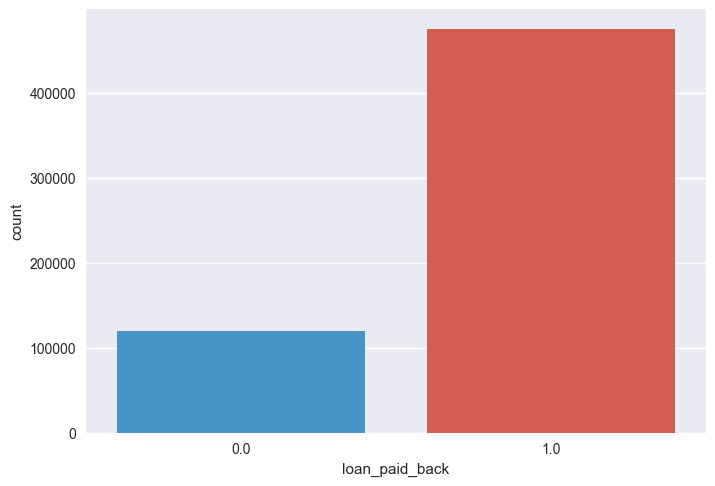

In [9]:
sns.countplot(data=train, x="loan_paid_back", palette=["#3498db", "#e74c3c"])

In [5]:
num_features = train.select_dtypes(include=['int64', 'float64']).drop(columns=['loan_paid_back', 'id']).columns.tolist()
cat_features = train.select_dtypes(include=['object']).columns.tolist()

array([[<Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'debt_to_income_ratio'}>],
       [<Axes: title={'center': 'credit_score'}>,
        <Axes: title={'center': 'loan_amount'}>],
       [<Axes: title={'center': 'interest_rate'}>, <Axes: >]],
      dtype=object)

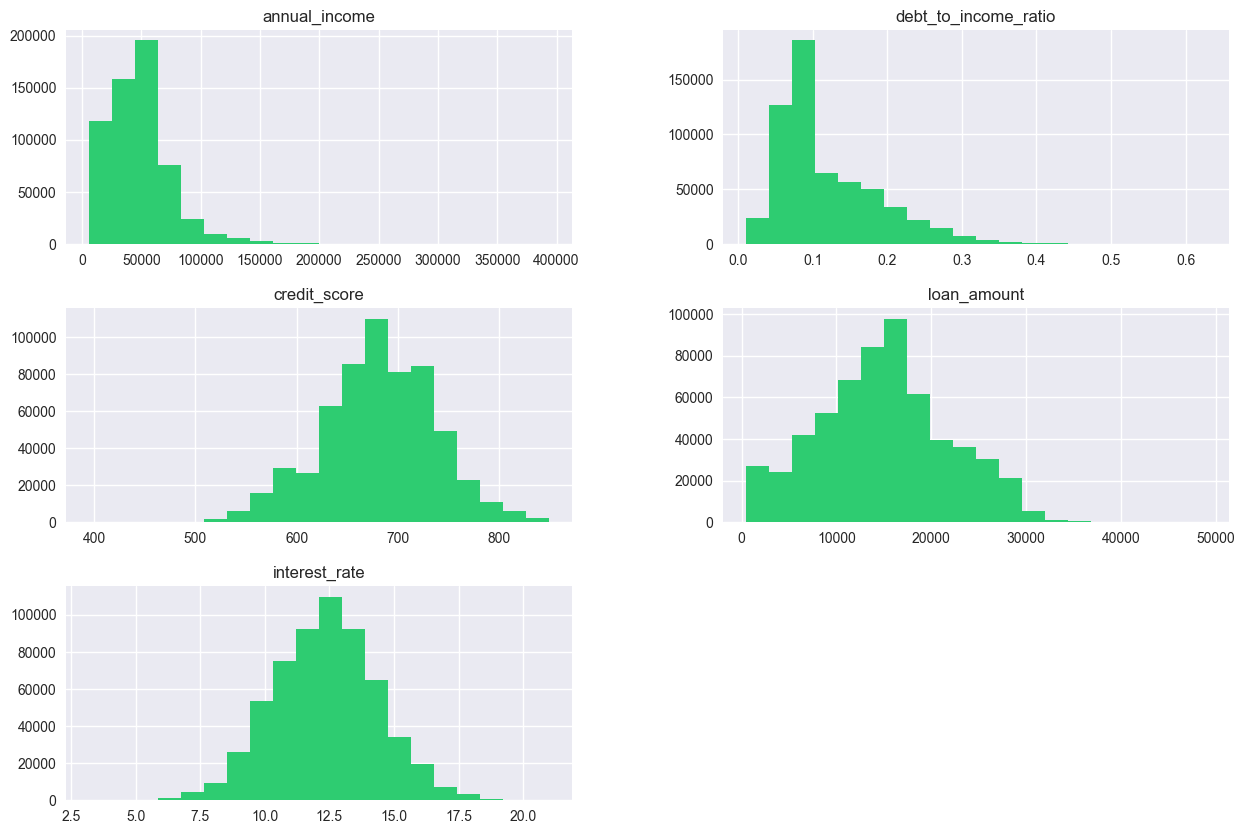

In [18]:
train[num_features].hist(figsize=(15, 10), bins=20, color="#2ecc71")

<Axes: >

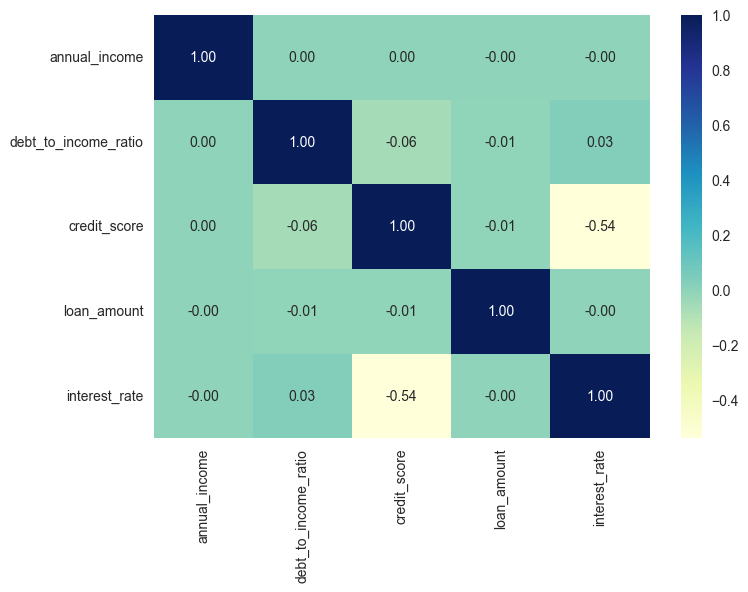

In [19]:
#correlation matrix
sns.heatmap(train[num_features].corr(), annot=True, fmt=".2f", cmap="YlGnBu")

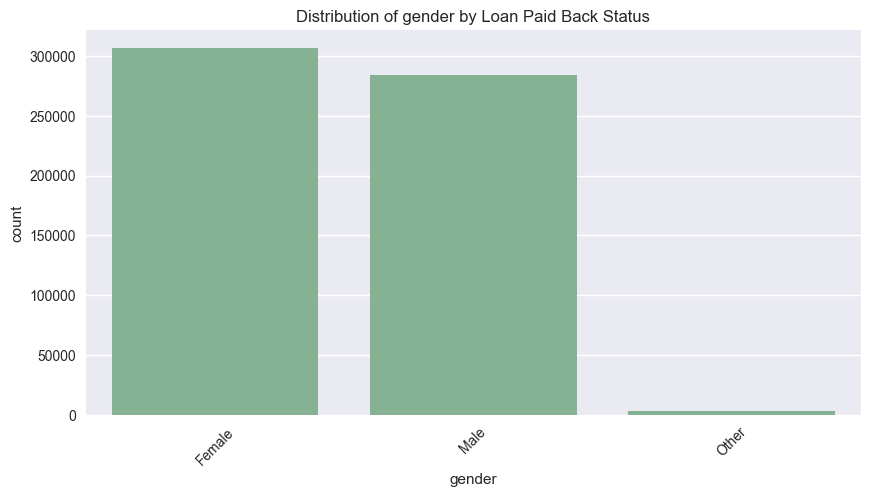

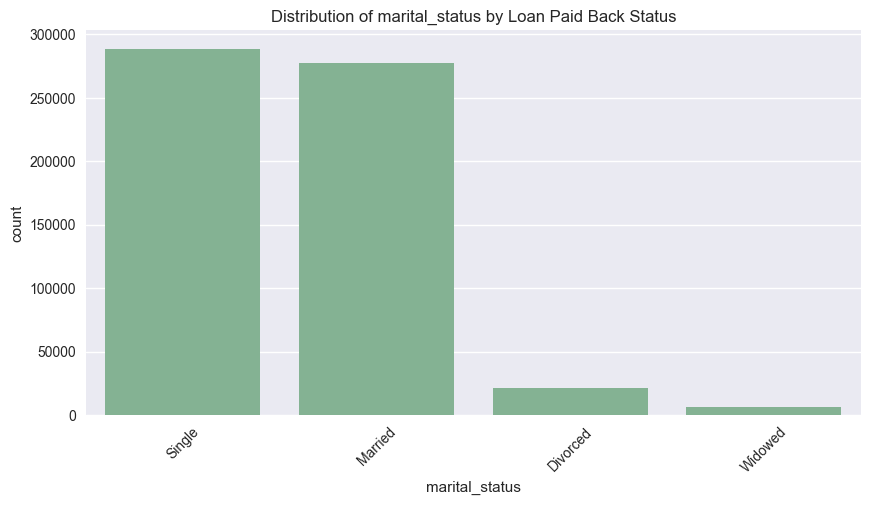

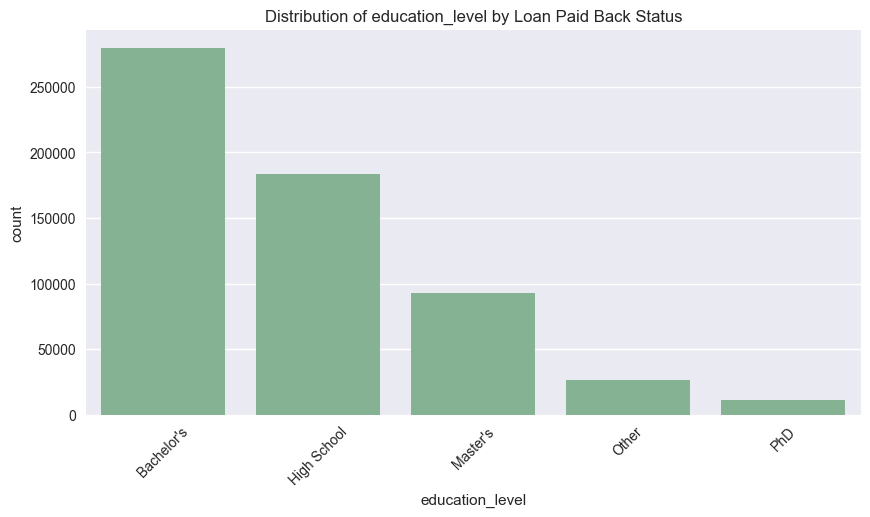

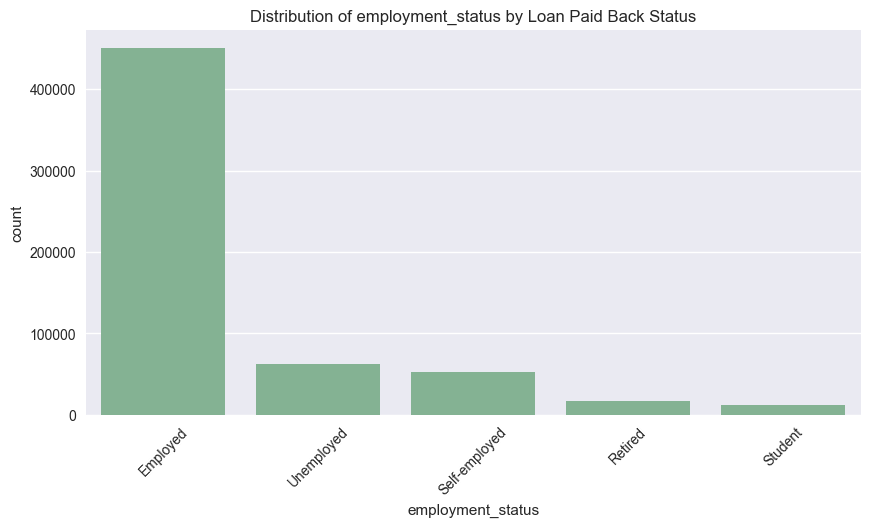

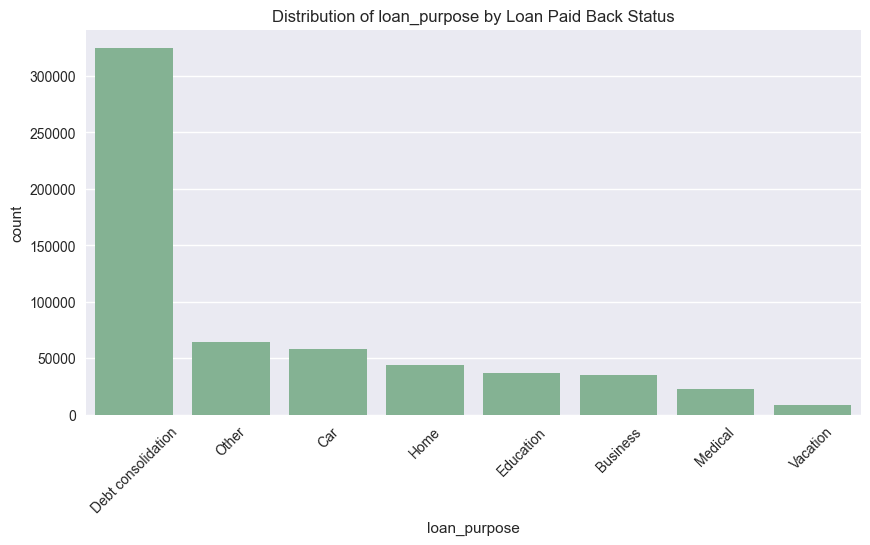

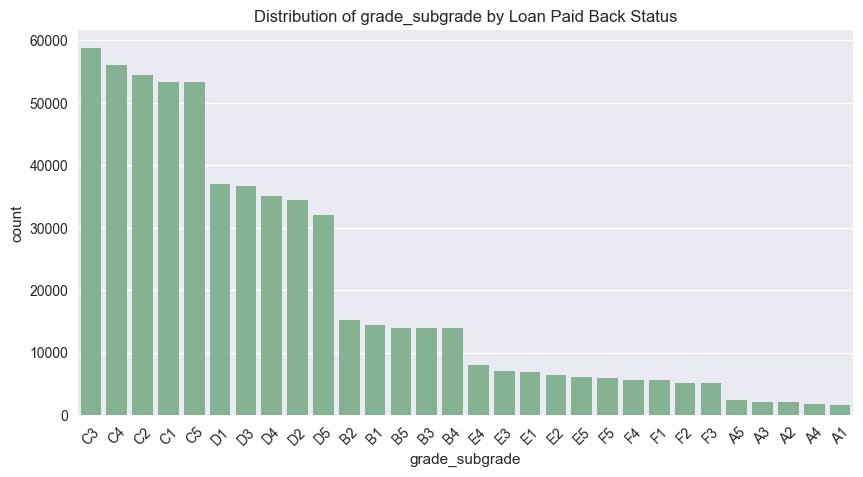

In [21]:
# Categorical 
for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train, x=col, order =train[col].value_counts().index)
    plt.title(f"Distribution of {col} by Loan Paid Back Status")
    plt.xticks(rotation=45)
    plt.show()

# Model training

In [3]:
X = train.drop(columns=["loan_paid_back"])
y = train["loan_paid_back"]

num_cols = X.select_dtypes(include=['int64', 'float64']).drop(columns=['id']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transfomer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
,
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transfomer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])



# Naive XGBoost

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform


In [5]:
clf = Pipeline([
    ("pre", preprocessor),  
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="auc", n_jobs=-1, random_state=42))
])


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
print("Baseline ROC AUC: %.4f ± %.4f" % (baseline_scores.mean(), baseline_scores.std()))


Baseline ROC AUC: 0.9203 ± 0.0007


In [7]:
param_dist = {
    "clf__n_estimators": randint(100, 1000),
    "clf__max_depth": randint(3, 10),
    "clf__learning_rate": uniform(0.01, 0.3),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.5, 0.5),
    "clf__reg_alpha": uniform(0.0, 1.0),
    "clf__reg_lambda": uniform(0.0, 1.0)
}

In [8]:
rs = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [9]:
rs.fit(X, y)
print("Best CV ROC AUC:", rs.best_score_)
print("Best params:", rs.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\as\miniconda3\envs\general\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:49:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV ROC AUC: 0.9220855554834033
Best params: {'clf__colsample_bytree': np.float64(0.6616014660103776), 'clf__learning_rate': np.float64(0.16563718652300982), 'clf__max_depth': 3, 'clf__n_estimators': 791, 'clf__reg_alpha': np.float64(0.363629602379294), 'clf__reg_lambda': np.float64(0.9717820827209607), 'clf__subsample': np.float64(0.9849789179768444)}


In [14]:
final_model = rs.best_estimator_
final_model.fit(X, y)

c:\Users\as\miniconda3\envs\general\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:09:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
probs = final_model.predict_proba(test.drop(columns=["id"]))[:, 1]

In [ ]:
sample["loan_paid_back"] = (probs>0.5).astype(int)
sample.to_csv("submission.csv", index=False)


# Class imbalance handling, early stopping

In [ ]:

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# stratified train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)

# fit preprocessor only on training data
preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(test.drop(columns=["id"]))

# handle class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# XGBoost with early stopping
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="auc",
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=50,
)

xgb.fit(
    X_train_p, y_train,
    eval_set=[(X_val_p, y_val)],
    verbose=20
)

# validation score and diagnostics
val_probs = xgb.predict_proba(X_val_p)[:, 1]
print("Val ROC AUC:", roc_auc_score(y_val, val_probs))
print("Best iteration:", getattr(xgb, "best_iteration", None))

# predict on test and write submission
probs = xgb.predict_proba(X_test_p)[:, 1]
sample["loan_paid_back"] = (probs > 0.5).astype(int)
sample.to_csv("submission_earlystop.csv", index=False)
# ...existing code...

[0]	validation_0-auc:0.90657


c:\Users\as\miniconda3\envs\general\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[20]	validation_0-auc:0.91126
[40]	validation_0-auc:0.91261
[60]	validation_0-auc:0.91368
[80]	validation_0-auc:0.91434
[100]	validation_0-auc:0.91484
[120]	validation_0-auc:0.91550
[140]	validation_0-auc:0.91593
[160]	validation_0-auc:0.91623
[180]	validation_0-auc:0.91670
[200]	validation_0-auc:0.91713
[220]	validation_0-auc:0.91738
[240]	validation_0-auc:0.91769
[260]	validation_0-auc:0.91799
[280]	validation_0-auc:0.91816
[300]	validation_0-auc:0.91834
[320]	validation_0-auc:0.91850
[340]	validation_0-auc:0.91869
[360]	validation_0-auc:0.91885
[380]	validation_0-auc:0.91900
[400]	validation_0-auc:0.91910
[420]	validation_0-auc:0.91926
[440]	validation_0-auc:0.91933
[460]	validation_0-auc:0.91947
[480]	validation_0-auc:0.91959
[500]	validation_0-auc:0.91971
[520]	validation_0-auc:0.91980
[540]	validation_0-auc:0.91984
[560]	validation_0-auc:0.91997
[580]	validation_0-auc:0.92002
[600]	validation_0-auc:0.92004
[620]	validation_0-auc:0.92006
[640]	validation_0-auc:0.92008
[660]	valida